<a href="https://colab.research.google.com/github/wcl20/Imperial-460/blob/master/CW3/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coursework 3: Part A - RNNs

#### Instructions

Please submit on CATe a zip file named *CW3_RNNs.zip* containing a version of this notebook containing your answers. Write your answers in the cells below each question.


#### Working environment:

Similarly to the previous coursework, we recommend that you use Google Colaboratory in order to train the required networks.

**The deadline for submission is 19:00, Thursday 5th March, 2020**

## Recurrent models coursework

This coursework is separated into a coding and a theory component.

For the first part, you will use the Google Speech Commands v0.02 subset that you used in the tutorial part: http://www.doc.ic.ac.uk/~pam213/co460_files/ 

### Part 1 - Coding (70%)
In this part you will have to:

#### Part 1.1 (20%)

Implement the LSTM RNN cell.

#### Part 1.2 (30%)

- Modify the RNNModel class, such that it is a Bidirectional RNN.
- Compare vanilla RNN, GRU, LSTM, and bidirectional VS unidirectional RNNs and report their performance with respect to accuracy and time cost.

#### Part 1.3 (20%)

Then for your best model you will perform some improvements:
- In terms of architecture optimisation (number of layers, hidden state dimension)
- Better utilisation of the hidden state sequence output by the RNN, for classification.
- Report the improvements you achieved, as well as an explanation for why they worked.

### Part 2 - Theory (30%)

Here you will answer some theoretical questions about RNN training, and CTC -- no detailed proofs and no programming.

### Part 1: Coding

### Dataset

We will be using the Google [*Speech Commands*](https://www.tensorflow.org/tutorials/sequences/audio_recognition) v0.02 [1] dataset.

[1] Warden, P. (2018). [Speech commands: A dataset for limited-vocabulary speech recognition](https://arxiv.org/abs/1804.03209). *arXiv preprint arXiv:1804.03209.*

For the first part, you will use the Google Speech Commands v0.02 subset that you used in the tutorial part: http://www.doc.ic.ac.uk/~pam213/co460_files/ 

Set-up code and imports

In [0]:
import math
import os
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset
import numpy as np
from scipy.io.wavfile import read
import librosa
from matplotlib import pyplot as plt

cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

if not os.path.exists('./data'):
    os.makedirs('./data')

In [0]:
!wget https://www.doc.ic.ac.uk/~pam213/co460_files/data_speech_commands_v0.02.zip
!unzip data_speech_commands_v0.02.zip -d "data/data_speech_commands_v0.02/"

Data provider class definition.

Here you can give different configuration to the [mfcc function](https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html). Additional keyword arguments are defined in the [melspectrogram function](https://librosa.github.io/librosa/generated/librosa.feature.melspectrogram.html#librosa.feature.melspectrogram).

One may additionally consider standardising the samples (remove mean, divide by std) or performing data augmentation, e.g., by adding low variance white or noise.

In [0]:
class SpeechCommandsDataset(Dataset):
    """Google Speech Commands dataset."""

    def __init__(self, root_dir, split):
        """
        Args:
            root_dir (string): Directory with all the data files.
            split    (string): In ["train", "valid", "test"].
        """
        self.root_dir = root_dir
        self.split = split

        self.number_of_classes = len(self.get_classes())

        self.class_to_file = defaultdict(list)

        self.valid_filenames = self.get_valid_filenames()
        self.test_filenames = self.get_test_filenames()

        for c in self.get_classes():
            file_name_list = sorted(os.listdir(self.root_dir + "/data_speech_commands_v0.02/" + c))
            for filename in file_name_list:
                if split == "train":
                    if (filename not in self.valid_filenames[c]) and (filename not in self.test_filenames[c]):
                        self.class_to_file[c].append(filename)
                elif split == "valid":
                    if filename in self.valid_filenames[c]:
                        self.class_to_file[c].append(filename)
                elif split == "test":
                    if filename in self.test_filenames[c]:
                        self.class_to_file[c].append(filename)
                else:
                    raise ValueError("Invalid split name.")

        self.filepath_list = list()
        self.label_list = list()
        for cc, c in enumerate(self.get_classes()):
            f_extension = sorted(list(self.class_to_file[c]))
            l_extension = [cc for i in f_extension]
            f_extension = [self.root_dir + "/data_speech_commands_v0.02/" + c + "/" + filename for filename in f_extension]
            self.filepath_list.extend(f_extension)
            self.label_list.extend(l_extension)
        self.number_of_samples = len(self.filepath_list)

    def __len__(self):
        return self.number_of_samples

    def __getitem__(self, idx):
        sample = np.zeros((16000, ), dtype=np.float32)

        sample_file = self.filepath_list[idx]

        sample_from_file = read(sample_file)[1]
        sample[:sample_from_file.size] = sample_from_file
        sample = sample.reshape((16000, ))
        
        ########################################################################
        ## YOU MAY CONFIGURE HERE.
        ########################################################################
        sample = librosa.feature.mfcc(y=sample, sr=16000, hop_length=512, n_fft=2048).transpose().astype(np.float32)
        ########################################################################
        ## DO NOT CONFIGURE BEYOND HERE.
        ########################################################################
        
        label = self.label_list[idx]

        return sample, label

    def get_classes(self):
        return ['one', 'two', 'three']

    def get_valid_filenames(self):
        class_names = self.get_classes()

        class_to_filename = defaultdict(set)
        with open(self.root_dir + "/data_speech_commands_v0.02/validation_list.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

    def get_test_filenames(self):
        class_names = self.get_classes()

        class_to_filename = defaultdict(set)
        with open(self.root_dir + "/data_speech_commands_v0.02/testing_list.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

Load Dataset - you may vary batch size.

In [0]:
## MAKE SURE THIS POINTS INSIDE THE DATASET FOLDER.
dataset_folder = "data" # this should change depending on where you have stored the data files

train_dataset = SpeechCommandsDataset(dataset_folder,
                                      "train")
valid_dataset = SpeechCommandsDataset(dataset_folder,
                                      "valid")

test_dataset = SpeechCommandsDataset(dataset_folder,
                                     "test")

## YOU MAY CHANGE THE BATCH SIZE.
batch_size = 100


num_epochs = 5
valid_every_n_steps = 20
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

## Part 1.1 (20%)

Finalise the LSTM cell (you can base your code on that of the GRU cell).

You are allowed to use nn.Linear.

In [0]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################

        # Input gate (x2h and h2h)
        self.inputU = nn.Linear(input_size, hidden_size, bias=bias)
        self.inputW = nn.Linear(hidden_size, hidden_size, bias=bias)
        # Forget gate (x2h and h2h)
        self.forgetU = nn.Linear(input_size, hidden_size, bias=bias)
        self.forgetW = nn.Linear(hidden_size, hidden_size, bias=bias)
        # Cell gate (x2h and h2h)
        self.cellU = nn.Linear(input_size, hidden_size, bias=bias)
        self.cellW = nn.Linear(hidden_size, hidden_size, bias=bias)
        # Output gate (x2h and h2h)
        self.outputU = nn.Linear(input_size, hidden_size, bias=bias)
        self.outputW = nn.Linear(hidden_size, hidden_size, bias=bias)

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)
            hx = (hx, hx)
            
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################

        # Get h and C from previous time step
        hx, cx = hx
        # Calculate it = sigmoid(xU_i + hW_i)
        i = torch.sigmoid(self.inputU(input) + self.inputW(hx))
        # Calculate ft = sigmoid(xU_f + hW_f)
        f = torch.sigmoid(self.forgetU(input) + self.inputW(hx))
        # Calculate Ct = tanh(xU_c + hW_c)
        c = torch.tanh(self.cellU(input) + self.cellW(hx))
        # Calculate Ot = sigmoid(xU_o + hW_o)
        o = torch.sigmoid(self.outputU(input) + self.outputW(hx))
        # Calculate next C
        cy = torch.mul(f, cx) + torch.mul(i, c)
        # Calculate next h
        hy = torch.mul(o, torch.tanh(cy))
        
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        return (hy, cy)

class BasicRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True, nonlinearity="tanh"):
        super(BasicRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.nonlinearity = nonlinearity
        if self.nonlinearity not in ["tanh", "relu"]:
            raise ValueError("Invalid nonlinearity selected for RNN.")

        self.x2h = nn.Linear(input_size, hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=bias)

        self.reset_parameters()
        

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

            
    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        
        z = self.x2h(input) + self.h2h(hx)
        hy = torch.tanh(z) if self.nonlinearity == "tanh" else F.relu(z)
        
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
            
        return hy

    
    
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################

        # Update gate (x2h and h2h)
        self.updateU = nn.Linear(input_size, hidden_size, bias=bias)
        self.updateW = nn.Linear(hidden_size, hidden_size, bias=bias)
        # Reset gate (x2h and h2h)
        self.resetU = nn.Linear(input_size, hidden_size, bias=bias)
        self.resetW = nn.Linear(hidden_size, hidden_size, bias=bias)
        # New gate (x2h and h2h)
        self.newU = nn.Linear(input_size, hidden_size, bias=bias)
        self.newW = nn.Linear(hidden_size, hidden_size, bias=bias)
     
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        self.reset_parameters()
        

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################

        # Calculate update zt = sigmoid(xU_u + hW_u)
        z = torch.sigmoid(self.updateU(input) + self.updateW(hx))
        # Calcuate reset rt = sigmoid(xU_r + hW_r)
        r = torch.sigmoid(self.resetU(input) + self.resetW(hx))
        # Calculate ht = tanh(xU_n + (r * hx)W_n)
        h = torch.tanh(self.newU(input) + self.newW(torch.mul(r, hx)))
        # Calculate next h 
        hy = h + torch.mul(z, (hx - h))

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        return hy

In [0]:
class RNNModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size):
        super(RNNModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        
        self.rnn_cell_list = nn.ModuleList()
        
        if mode == 'LSTM':
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
            self.rnn_cell_list.append(LSTMCell(self.input_size, self.hidden_size, self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(LSTMCell(self.hidden_size, self.hidden_size, self.bias))
           
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        elif mode == 'GRU':
            self.rnn_cell_list.append(GRUCell(self.input_size, self.hidden_size, self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(GRUCell(self.hidden_size, self.hidden_size, self.bias))

        elif mode == 'RNN_TANH':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size, self.hidden_size, self.bias, "tanh"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size, self.hidden_size, self.bias, "tanh"))

        elif mode == 'RNN_RELU':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size, self.hidden_size, self.bias, "relu"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size, self.hidden_size, self.bias, "relu"))
        else:
            raise ValueError("Invalid RNN mode selected.")


        self.att_fc = nn.Linear(self.hidden_size, 1)
        self.fc = nn.Linear(self.hidden_size, self.output_size)

        
    def forward(self, input, hx=None):
        if hx is None:
            if torch.cuda.is_available():
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
            else:
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))

        else:
             h0 = hx

        outs = []

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        # Get Sequence dimension
        seq_dim = input.size(1)

        if self.mode == "LSTM":
            if torch.cuda.is_available():
                c0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
            else:
                c0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))
            # Unfold RNN to each time step
            for t in range(seq_dim):
                x = input[:, t, :]
                # For each layer
                for layer, cell in enumerate(self.rnn_cell_list):
                    # Calculate output of a cell (input of next layer)
                    x, cy = cell.forward(x, (h0[layer].clone(), c0[layer].clone()))
                    # Update h and c
                    h0[layer] = x
                    c0[layer] = cy
                # Append final output to list of outputs
                outs.append(x)
        else:
            # Unfold RNN to each time step
            for t in range(seq_dim):
                x = input[:, t, :]
                # For each layer
                for layer, cell in enumerate(self.rnn_cell_list):
                    # Calculate output of a cell (input of next layer)
                    x = cell.forward(x, h0[layer].clone())
                    # Update h
                    h0[layer] = x
                # Append final output to list of outputs
                outs.append(x)

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        out = outs[-1].squeeze() # Related to Part 1.3.

        out = self.fc(out)
        
        
        return out
    

class BidirRecurrentModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size):
        super(BidirRecurrentModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        
        # Foward model
        self.rnn_cell_list = nn.ModuleList()
        # Backward model
        self.rnn_cell_list_rev = nn.ModuleList()
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################

        if mode == "LSTM":
            self.rnn_cell_list.append(LSTMCell(self.input_size, self.hidden_size, self.bias))
            self.rnn_cell_list_rev.append(LSTMCell(self.input_size, self.hidden_size, self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(LSTMCell(self.hidden_size, self.hidden_size, self.bias))
                self.rnn_cell_list_rev.append(LSTMCell(self.hidden_size, self.hidden_size, self.bias))
        
        elif mode == 'RNN_TANH':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size, self.hidden_size, self.bias, "tanh"))
            self.rnn_cell_list_rev.append(BasicRNNCell(self.input_size, self.hidden_size, self.bias, "tanh"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size, self.hidden_size, self.bias, "tanh"))
                self.rnn_cell_list_rev.append(BasicRNNCell(self.hidden_size, self.hidden_size, self.bias, "tanh"))

        elif mode == 'RNN_RELU':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size, self.hidden_size, self.bias, "relu"))
            self.rnn_cell_list_rev.append(BasicRNNCell(self.input_size, self.hidden_size, self.bias, "relu"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size, self.hidden_size, self.bias, "relu"))
                self.rnn_cell_list_rev.append(BasicRNNCell(self.hidden_size, self.hidden_size, self.bias, "relu"))

        elif mode == "GRU":
            self.rnn_cell_list.append(GRUCell(self.input_size, self.hidden_size, self.bias))
            self.rnn_cell_list_rev.append(GRUCell(self.input_size, self.hidden_size, self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(GRUCell(self.hidden_size, self.hidden_size, self.bias))
                self.rnn_cell_list_rev.append(GRUCell(self.hidden_size, self.hidden_size, self.bias))
        else:
            raise ValueError("Invalid RNN mode selected.")
        
        self.fc = nn.Linear(2 * self.hidden_size, self.output_size)

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        
    def forward(self, input, hx=None):
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
            hT = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
        else:
            h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))
            hT = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))
            
        outs = []
        outs_rev = []
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        # Get Sequence dimension
        seq_dim = input.size(1)

        if self.mode == "LSTM":
            if torch.cuda.is_available():
                c0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
                cT = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
            else:
                c0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))
                cT = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))
            
            # For each time step
            for t in range(seq_dim):
                # Input for Forward model
                x = input[:, t, :]
                # Input for Backward model
                x_rev = input[:, seq_dim - t - 1, :]
                for layer in range(self.num_layers):
                    # Forward model
                    x, cy = self.rnn_cell_list[layer].forward(x, (h0[layer].clone(), c0[layer].clone()))
                    # Update h and c for Forward model
                    h0[layer] = x
                    c0[layer] = cy
                    # Backward model
                    x_rev, cy_rev = self.rnn_cell_list_rev[layer].forward(x_rev, (hT[layer].clone(), cT[layer].clone()))
                    # Update h and c for backeward model
                    hT[layer] = x_rev
                    cT[layer] = cy_rev
                # Append output
                outs.append(x)
                outs_rev.append(x)
            
        else:
            # Forward each time step
            for t in range(seq_dim):
                x = input[:, t, :]
                x_rev = input[:, seq_dim - t - 1, :]
                for layer in range(self.num_layers):
                    x = self.rnn_cell_list[layer].forward(x, h0[layer].clone())
                    h0[layer] = x
                    x_rev = self.rnn_cell_list_rev[layer].forward(x_rev, hT[layer].clone())
                    hT[layer] = x_rev
                outs.append(x)
                outs_rev.append(x)
      
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        # For part 1.2
        # out = outs[-1].squeeze()  # Related to question 10.
        # out_rev = outs_rev[0].squeeze()

        # For part 1.3
        out = torch.mean(torch.stack(outs), 0)
        out_rev = torch.mean(torch.stack(outs_rev), 0)

        out = torch.cat((out, out_rev), 1)

        out = self.fc(out)
        return out

## Part 1.2 (30%)

In the following, experiment with different RNN architectures (RNN cell types, number of layers, hidden state dimensionality, MFCC configuration, unidirectional VS bidirectional) and report the accuracy (pay also attention to the training and validation cost), as well as training time. 

* What are your justifications for these results?

* On the notebook, leave the execution of your best model.

### Answer

Comparing the accuracies, BidirectionalRNN has better performance than RNNModel. This is because BidirectionalRNN uses two hidden layers in opposite direction to utilize information from past and future states simultaneously. LSTM and GRU have similar performance whereas vanilly RNN model performed the worst. This is expected because vanilla RNN suffers from vanishing and exploding gradients and does not have mechanism to preserve long term information.

Training time increases proportionately to the number of training parameters. Therefore vanilla RNN uses the shortest time, follow by GRU, LSTM, and BidirectionalRNN takes the longests time to train.

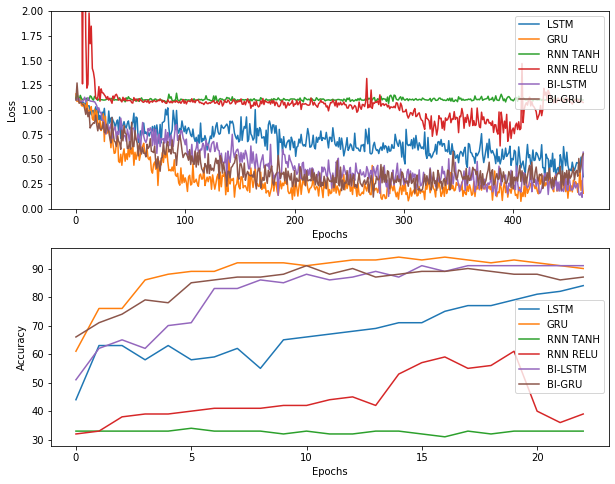

In [0]:
# Parts of experiment code based on: https://github.com/emadRad/lstm-gru-pytorch

seq_dim, input_dim = train_dataset[0][0].shape
output_dim = 3

## YOU MAY CONFIGURE THESE.
hidden_dim = 32
layer_dim = 2
bias = True

models = [
        RNNModel("LSTM", input_dim, hidden_dim, layer_dim, bias, output_dim),
        RNNModel("GRU", input_dim, hidden_dim, layer_dim, bias, output_dim),
        RNNModel("RNN_TANH", input_dim, hidden_dim, layer_dim, bias, output_dim),
        RNNModel("RNN_RELU", input_dim, hidden_dim, layer_dim, bias, output_dim),
        BidirRecurrentModel("LSTM", input_dim, hidden_dim, layer_dim, bias, output_dim),
        BidirRecurrentModel("GRU", input_dim, hidden_dim, layer_dim, bias, output_dim) 
]

names = ["LSTM", "GRU", "RNN TANH", "RNN RELU", "BI-LSTM", "BI-GRU"]

# Plot Graphs
fig, (ax1, ax2) = plt.subplots(2)
fig.set_figwidth(10)
fig.set_figheight(8)

for index, model in enumerate(models):

    if torch.cuda.is_available():
        model.cuda()
        
    criterion = nn.CrossEntropyLoss()

    ## YOU MAY CONFIGURE THESE.
    learning_rate = 0.01
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    loss_list = []
    accuracy_list = []
    iter = 0
    for epoch in range(num_epochs):
        for i, (audio, labels) in enumerate(train_loader):
            if torch.cuda.is_available():
                audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                labels = Variable(labels.cuda())
            else:
                audio = Variable(audio.view(-1, seq_dim, input_dim))
                labels = Variable(labels)

            optimizer.zero_grad()

            outputs = model(audio)

            loss = criterion(outputs, labels)

            if torch.cuda.is_available():
                loss.cuda()

            loss.backward()

            optimizer.step()

            loss_list.append(loss.item())
            iter += 1

            if iter % valid_every_n_steps == 0:
                correct = 0
                total = 0
                for audio, labels in valid_loader:
                    if torch.cuda.is_available():
                        audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                    else:
                        audio = Variable(audio.view(-1, seq_dim, input_dim))

                    outputs = model(audio)

                    _, predicted = torch.max(outputs.data, 1)

                    total += labels.size(0)

                    if torch.cuda.is_available():
                        correct += (predicted.cpu() == labels.cpu()).sum()
                    else:
                        correct += (predicted == labels).sum()

                v_accuracy = 100 * correct / total
                accuracy_list.append(v_accuracy)
                
    ax1.plot(list(range(len(loss_list))), loss_list, label=names[index])
    ax2.plot(list(range(len(accuracy_list))), accuracy_list, label=names[index])

ax1.legend()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_ylim([0, 2])
ax2.legend()
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
plt.show()

In [0]:
# Parts of experiment code based on: https://github.com/emadRad/lstm-gru-pytorch

seq_dim, input_dim = train_dataset[0][0].shape
output_dim = 3

## YOU MAY CONFIGURE THESE.
hidden_dim = 32
layer_dim = 2
bias = True

#model = RNNModel("LSTM", input_dim, hidden_dim, layer_dim, bias, output_dim)
model = BidirRecurrentModel("LSTM", input_dim, hidden_dim, layer_dim, bias, output_dim)

if torch.cuda.is_available():
    model.cuda()
    
criterion = nn.CrossEntropyLoss()

## YOU MAY CONFIGURE THESE.
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list = []
iter = 0
max_v_accuracy = 0
reported_t_accuracy = 0
max_t_accuracy = 0
for epoch in range(num_epochs):
    for i, (audio, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            audio = Variable(audio.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        optimizer.zero_grad()

        outputs = model(audio)

        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()

        optimizer.step()

        loss_list.append(loss.item())
        iter += 1

        if iter % valid_every_n_steps == 0:
            correct = 0
            total = 0
            for audio, labels in valid_loader:
                if torch.cuda.is_available():
                    audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                else:
                    audio = Variable(audio.view(-1, seq_dim, input_dim))

                outputs = model(audio)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            v_accuracy = 100 * correct / total
            
            is_best = False
            if v_accuracy >= max_v_accuracy:
                max_v_accuracy = v_accuracy
                is_best = True

            if is_best:
                for audio, labels in test_loader:
                    if torch.cuda.is_available():
                        audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                    else:
                        audio = Variable(audio.view(-1, seq_dim, input_dim))

                    outputs = model(audio)

                    _, predicted = torch.max(outputs.data, 1)

                    total += labels.size(0)

                    if torch.cuda.is_available():
                        correct += (predicted.cpu() == labels.cpu()).sum()
                    else:
                        correct += (predicted == labels).sum()

                t_accuracy = 100 * correct / total
                reported_t_accuracy = t_accuracy

            print('Iteration: {}. Loss: {}. V-Accuracy: {}  T-Accuracy: {}'.format(iter, loss.item(), v_accuracy, reported_t_accuracy))



Iteration: 20. Loss: 1.0574337244033813. V-Accuracy: 52  T-Accuracy: 52
Iteration: 40. Loss: 0.9387692213058472. V-Accuracy: 50  T-Accuracy: 52
Iteration: 60. Loss: 0.6424064040184021. V-Accuracy: 61  T-Accuracy: 59
Iteration: 80. Loss: 0.6984209418296814. V-Accuracy: 68  T-Accuracy: 68
Iteration: 100. Loss: 0.6576260328292847. V-Accuracy: 67  T-Accuracy: 68
Iteration: 120. Loss: 0.5934838652610779. V-Accuracy: 74  T-Accuracy: 74
Iteration: 140. Loss: 0.504912257194519. V-Accuracy: 78  T-Accuracy: 77
Iteration: 160. Loss: 0.5784172415733337. V-Accuracy: 79  T-Accuracy: 78
Iteration: 180. Loss: 0.5340006351470947. V-Accuracy: 82  T-Accuracy: 81
Iteration: 200. Loss: 0.44600769877433777. V-Accuracy: 82  T-Accuracy: 82
Iteration: 220. Loss: 0.4249154329299927. V-Accuracy: 81  T-Accuracy: 82
Iteration: 240. Loss: 0.584929347038269. V-Accuracy: 82  T-Accuracy: 81
Iteration: 260. Loss: 0.3826613128185272. V-Accuracy: 85  T-Accuracy: 84
Iteration: 280. Loss: 0.49577751755714417. V-Accuracy: 8

## Part 1.3 (20%)

RNN hidden state. In the code above in the RNNModel and BidirRecurrentModel, we utilise the final hidden state extracted by the model in order to make the final pass through a feed-forward layer towards a final prediction.

a) Can you think of reasons this might not be the best choice? Please write down two variations that could possibly yield better result.

b) Experiment with such alternative approaches in the code below in order to achieve a better result and report it below.

### Answer
a) At each time step, the RNNModel returns an output that can be used to make predictions. In part 1.2, we computed the whole output sequence but only utilized the last output state for prediction. Ignoring all the intermediate outcomes losses a lot of information that might potentially improve the accuracy of the final prediction. There are two variations that could possibly yield better results:

* Taking the average of all outcomes before passing through the feed-forward layer towards a final predicition.

* Similar to the first approach, but istead find the weighted average of all the outcomes before passing through the feed-forward layer towards a final prediction. Each outcome can be assigned different weight based on its influence on the final prediction.

b) The following code uses the first approach. It utilizes all the hidden states from the forward and backward pass by calculating the average for all states.

In [0]:
# Parts of experiment code based on: https://github.com/emadRad/lstm-gru-pytorch

# Add the model that has got the best results for you after after Part 1.2 and Part 1.3

seq_dim, input_dim = train_dataset[0][0].shape
output_dim = 3

## YOU MAY CONFIGURE THESE.
hidden_dim = 32
layer_dim = 2
bias = True

# model = RNNModel("GRU", input_dim, hidden_dim, layer_dim, bias, output_dim)
model = BidirRecurrentModel("LSTM", input_dim, hidden_dim, layer_dim, bias, output_dim)

if torch.cuda.is_available():
    model.cuda()
    
criterion = nn.CrossEntropyLoss()

## YOU MAY CONFIGURE THESE.
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list = []
iter = 0
max_v_accuracy = 0
reported_t_accuracy = 0
max_t_accuracy = 0
for epoch in range(num_epochs):
    for i, (audio, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            audio = Variable(audio.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        optimizer.zero_grad()

        outputs = model(audio)

        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()

        optimizer.step()

        loss_list.append(loss.item())
        iter += 1

        if iter % valid_every_n_steps == 0:
            correct = 0
            total = 0
            for audio, labels in valid_loader:
                if torch.cuda.is_available():
                    audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                else:
                    audio = Variable(audio.view(-1, seq_dim, input_dim))

                outputs = model(audio)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            v_accuracy = 100 * correct / total
            
            is_best = False
            if v_accuracy >= max_v_accuracy:
                max_v_accuracy = v_accuracy
                is_best = True

            if is_best:
                for audio, labels in test_loader:
                    if torch.cuda.is_available():
                        audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                    else:
                        audio = Variable(audio.view(-1, seq_dim, input_dim))

                    outputs = model(audio)

                    _, predicted = torch.max(outputs.data, 1)

                    total += labels.size(0)

                    if torch.cuda.is_available():
                        correct += (predicted.cpu() == labels.cpu()).sum()
                    else:
                        correct += (predicted == labels).sum()

                t_accuracy = 100 * correct / total
                reported_t_accuracy = t_accuracy

            print('Iteration: {}. Loss: {}. V-Accuracy: {}  T-Accuracy: {}'.format(iter, loss.item(), v_accuracy, reported_t_accuracy))



Iteration: 20. Loss: 0.779543936252594. V-Accuracy: 64  T-Accuracy: 62
Iteration: 40. Loss: 0.6083197593688965. V-Accuracy: 70  T-Accuracy: 69
Iteration: 60. Loss: 0.693846583366394. V-Accuracy: 72  T-Accuracy: 71
Iteration: 80. Loss: 0.5068857669830322. V-Accuracy: 80  T-Accuracy: 78
Iteration: 100. Loss: 0.7248765826225281. V-Accuracy: 65  T-Accuracy: 78
Iteration: 120. Loss: 0.5845907330513. V-Accuracy: 83  T-Accuracy: 83
Iteration: 140. Loss: 0.3244009017944336. V-Accuracy: 87  T-Accuracy: 86
Iteration: 160. Loss: 0.39589986205101013. V-Accuracy: 88  T-Accuracy: 88
Iteration: 180. Loss: 0.18344108760356903. V-Accuracy: 91  T-Accuracy: 90
Iteration: 200. Loss: 0.3404403626918793. V-Accuracy: 90  T-Accuracy: 90
Iteration: 220. Loss: 0.2253415733575821. V-Accuracy: 90  T-Accuracy: 90
Iteration: 240. Loss: 0.16191750764846802. V-Accuracy: 93  T-Accuracy: 92
Iteration: 260. Loss: 0.32122382521629333. V-Accuracy: 92  T-Accuracy: 92
Iteration: 280. Loss: 0.2519382834434509. V-Accuracy: 92

## Part 2: Theoretical questions (30%)

Please answer the following theoretical questions in a cell below each respective question.

a. What is the _vanishing and exploding gradients problem_? When does it appear, and what is its practical significance? Please explain. (10%)

### Answer

In a Neural Network, information travels from input neuron to output neuron, an error is calculated and back propagated to update the weights. In an RNN, information from previous time steps is used as input for the next time step, so during training the error have to propagate through the whole time series.

The vanishing and exploding gradient problem relates to the recurring weight, the weight that connects the hidden layer to itself.

* When the recurring weight is small, the gradient becomes less and less with each multiplication during back propagation. Eventually, the gradient will become so small for the network to update its weight. This is known as the vanshing gradient problem.

* When the recurring weight is large, the gradient becomes larger with each mulitplication. This results in large updates for the network and the network will become unstable. This is known as the exploding gradient problem.

b. The following (cartoon) plots show the gradients and the training curves for three models A, B, and C, trained on the same dataset. The three models are a RNN, a LSTM and a GRU, not necessarily in that order. (10%)

* Which could plausibly be which? Why? Please explain your reasoning.
* For which kinds of problems would you elect to use each of them?

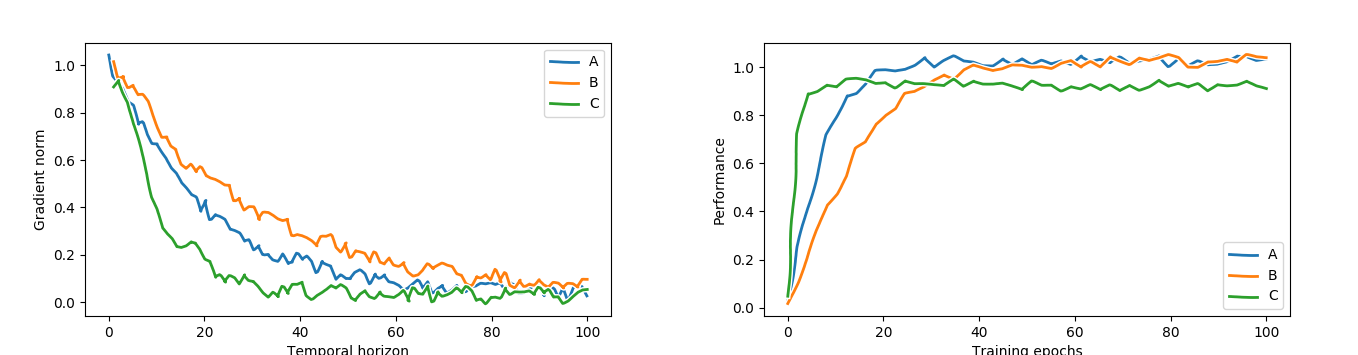

In [0]:
from IPython.display import Image, display
display(Image(filename='question_figs.png', width=850))

### Answer

From the performance graph, we can conclude model C is standard RNN because it has a lower performance. In general, RNN performs worse than LSTM and GRU because it suffers from vanishing and exploding gradient problems. LSTM and GRU use different gates to control gradient flow and has better preservation of long-term dependencies.

LSTM and GRU have similar performances. From the Gradient Norm graph, we can conclude that model A is GRU and model B is LSTM because model A took less time to train. This is because GRU uses less gate than LSTM, and so it has fewer parameters to train.

RNN is a generalization of feed-forward Neural Network that has internal memory. It make use of the internal memory to process sequence of inputs, making it applicable to task like connected handwriting recognition or speech recognition. RNN can be used for tasks that does not require much long term memory, whereas GRU and LSTM are better if the task has long-term dependencies. 

Comparing GRU and LSTM, GRU uses less parameters and therefore trains faster than LSTM but LSTM is more accurate on dataset using longer sequences.

c.  Write down five possible Connectionist Temporal Classification (CTC) paths (of no more than a length of eight) that correspond to the same label "LADDER". (10%)

### Answer

* LAD∅DER
* LLAD∅DER
* LAAD∅DER
* LADD∅DER
* LAD∅DDER